In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
from fastai.tabular import *
from fastai_tabtext2 import *
from fastai_tab_text import *
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import KFold

In [3]:
collate_fn = partial(mixed_tabular_pad_collate, pad_idx=1, pad_first=True)

In [4]:
def reset_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
reset_seed()

In [5]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.6.5
fastai        : 1.0.52
fastprogress  : 0.1.20
torch         : 1.0.1.post2
nvidia driver : 410.104
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.4.0-1087-aws-x86_64-with-debian-stretch-sid
distro        : #98-Ubuntu SMP Wed Jun 26 05:50:53 UTC 2019
conda env     : Unknown
python        : /home/ubuntu/anaconda3/bin/python
sys.path      : 
/home/ubuntu/src/cntk/bindings/python
/home/ubuntu/anaconda3/lib/python36.zip
/home/ubuntu/anaconda3/lib/python3.6
/home/ubuntu/anaconda3/lib/python3.6/lib-dynload
/home/ubuntu/anaconda3/lib/python3.6/site-packages
/home/ubuntu/anaconda3/lib/python3.6/site-packages/IPython/extensions
/home/ubuntu/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code section

In [6]:
gc.collect()

0

In [7]:
def get_val_idxs(train,n_splits=20):
    np.random.seed(42)
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_idxs, valid_idxs = next(cv.split(train))
    return train_idxs,valid_idxs

In [8]:
train_df = pd.read_csv('train.csv')
train = train_df.sample(int(len(train_df)*0.01)) # 5% of training set
print("printing number of documents in subset: {}".format(len(train)))

printing number of documents in subset: 2735


In [9]:
test_df = pd.read_csv('test.csv')
test = test_df.sample(int(len(test_df)*0.01))
print("printing number of documents in subset: {}".format(len(test)))

printing number of documents in subset: 681


In [10]:
train_df['school'] = train_df['school'].str.replace('Closed', '') # parse out closed label from school name

In [11]:
test_df['school'] = test_df['school'].str.replace('Closed', '') # parse out closed label from school name

In [12]:
print ("printing len of train_df: {}".format(len(train_df)))
print ("printing len of test_df: {}".format(len(test_df)))

printing len of train_df: 273517
printing len of test_df: 68166


In [13]:
train_df = train_df[train_df.date != ' ']
test_df = test_df[test_df.date != ' '] # remove entries with missing dates

In [14]:
train_df = train_df[train_df['school'].str.contains('[a-zA-Z]')]
test_df = test_df[test_df['school'].str.contains('[a-zA-Z]')]

In [15]:
print ("printing len of train_df after dropping: {}".format(len(train_df)))
print ("printing len of test_df after dropping: {}".format(len(test_df)))

printing len of train_df after dropping: 185548
printing len of test_df after dropping: 46356


In [16]:
print("number of closed schools in train_df: {}".format(len(train_df[train_df['label'] == 'closed'])))
print("number of open schools in train_df: {}".format(len(train_df[train_df['label'] == 'open'])))

number of closed schools in train_df: 50846
number of open schools in train_df: 134702


In [17]:
print("number of closed schools in test_df: {}".format(len(test_df[test_df['label'] == 'closed'])))
print("number of open schools in test_df: {}".format(len(test_df[test_df['label'] == 'open'])))

number of closed schools in test_df: 12875
number of open schools in test_df: 33481


In [18]:
# missing_school_names = pd.read_csv('closed_school_dates.csv')
# missing_school_names.head()

In [19]:
# missing_school_names = missing_school_names.rename(columns={'report': 'file'})

In [20]:
# ms = missing_school_names.copy()
# train_df = train_df.apply(lambda x: [ms[ms['file'] == x['file']].school.iloc[0], x['text'], x['label'], x['file'], x['date']]
#                if not ms[ms['file'] == x['file']].empty else x, axis=1, result_type='broadcast')

In [21]:
# test_df = test_df.apply(lambda x: [ms[ms['file'] == x['file']].school.iloc[0], x['text'], x['label'], x['file'], x['date']]
#                if not ms[ms['file'] == x['file']].empty else x, axis=1, result_type='broadcast')

In [22]:
gc.collect()

60

In [23]:
train.shape, test.shape

((2735, 5), (681, 5))

In [24]:
train.columns

Index(['school', 'text', 'label', 'file', 'date'], dtype='object')

In [25]:
train['school'] = train['school'].str.replace('Closed', '') # parse out closed label from school name

In [26]:
train = train[train.date != ' '] # remove entries with missing dates

In [27]:
mapping = {'closed': 0, 'open': 1}
train = train.applymap(lambda s: mapping.get(s) if s in mapping else s)

In [28]:
train.head()

,school,text,label,file,date
137283,Trench Tots Nursery,COMBINED INSPECTION REPORTURN EY DfES Num...,1,1587885,16 December 2009
114283,"St Joseph's Catholic Primary School, SWF",Piccadilly Gate Store Street Manchester M...,1,50021735,05 July 2018
45273,Cheveley Acorns Pre School,Cheveley Acorns Pre School Cheveley Aco...,0,2738269,24 March 2018
163090,URN: SC066393,s home SC SC Register...,1,2762627,28 December 2018
208159,Whittington Green School,School report The Meadows Community School...,1,2183749,29 September 2014


In [29]:
test['file'] = pd.to_numeric(test['file'])

In [30]:
train['school'] = train['school'].str.replace('Closed', '') # parse out closed label from school name

In [31]:
test = test[test.date != ' '] # remove entries with missing dates

In [32]:
test = test.applymap(lambda s: mapping.get(s) if s in mapping else s)

In [33]:
test.head()

,school,text,label,file,date
2213,Moat Street Pre-School Closed,UntitledMoat Street Pre School for s provision...,0,1093911,05 January 2012
18797,Cirencester Opportunity Group registration unt...,UntitledCencester Opportunity Group for s prov...,0,1138249,29 September 2011
65889,Marvel Pre-School,UntitledMarvel After School Club for s provisi...,1,1061613,09 November 2012
48600,Magic Roundabout Nurseries Ltd,Magic Roundabout Nurseries Limited S...,1,2542206,26 August 2016
65254,Squirrel Hayes First School,Page of December Mrs J BettsThe Hea...,1,907807,10 December 2008


In [34]:
train = train[train['school'].str.contains('[a-zA-Z]')]

In [35]:
print("printing number of documents in train after dropping : {}".format(len(train)))

printing number of documents in train after dropping : 1826


In [36]:
print("number of closed schools in train: {}".format(len(train[train['label'] == 0])))
print("number of open schools in train: {}".format(len(train[train['label'] == 1])))

number of closed schools in train: 507
number of open schools in train: 1319


In [37]:
test = test[test['school'].str.contains('[a-zA-Z]')]

In [38]:
print ("number of closed schools in test: {}".format(len(test[test['label'] == 0])))
print ("number of open schools in test: {}".format(len(test[test['label'] == 1])))

number of closed schools in test: 154
number of open schools in test: 314


In [39]:
print("printing number of documents in train after dropping : {}".format(len(test)))

printing number of documents in train after dropping : 468


In [40]:
train.to_csv('sample_train.csv')

In [41]:
test.to_csv('sample_test.csv')

In [42]:
add_datepart(train, 'date', drop=True)

,school,text,label,file,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
137283,Trench Tots Nursery,COMBINED INSPECTION REPORTURN EY DfES Num...,1,1587885,2009,12,51,16,2,350,False,False,False,False,False,False,1260921600
114283,"St Joseph's Catholic Primary School, SWF",Piccadilly Gate Store Street Manchester M...,1,50021735,2018,7,27,5,3,186,False,False,False,False,False,False,1530748800
45273,Cheveley Acorns Pre School,Cheveley Acorns Pre School Cheveley Aco...,0,2738269,2018,3,12,24,5,83,False,False,False,False,False,False,1521849600
163090,URN: SC066393,s home SC SC Register...,1,2762627,2018,12,52,28,4,362,False,False,False,False,False,False,1545955200
208159,Whittington Green School,School report The Meadows Community School...,1,2183749,2014,9,40,29,0,272,False,False,False,False,False,False,1411948800
69940,Kinder Kapers Too,Kinder Kapers Too Kingsley Hall Parslo...,0,2599635,2016,9,37,16,4,260,False,False,False,False,False,False,1473984000
205694,Michelle Linzi Judson,for s provisionUnique Reference Number EY ...,1,1023601,2014,12,52,24,2,358,False,False,False,False,False,False,1419379200
78626,Masham Church of England VA Primary School,UntitledMasham Church of EnglandVA Primary Sch...,1,820489,2012,3,12,20,1,80,False,False,False,False,False,False,1332201600
112739,Hawkedon Primary School,Piccadilly Gate Store Street Manchester M...,1,50032519,2018,9,39,26,2,269,False,False,False,False,False,False,1537920000
73060,New Haw Community Junior School,UntitledNew Haw Community JuniorSchool Un...,0,933883,2009,4,14,1,2,91,False,True,False,True,False,False,1238544000


In [43]:
add_datepart(test, 'date', drop=True)

,school,text,label,file,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
2213,Moat Street Pre-School Closed,UntitledMoat Street Pre School for s provision...,0,1093911,2012,1,1,5,3,5,False,False,False,False,False,False,1325721600
18797,Cirencester Opportunity Group registration unt...,UntitledCencester Opportunity Group for s prov...,0,1138249,2011,9,39,29,3,272,False,False,False,False,False,False,1317254400
65889,Marvel Pre-School,UntitledMarvel After School Club for s provisi...,1,1061613,2012,11,45,9,4,314,False,False,False,False,False,False,1352419200
48600,Magic Roundabout Nurseries Ltd,Magic Roundabout Nurseries Limited S...,1,2542206,2016,8,34,26,4,239,False,False,False,False,False,False,1472169600
65254,Squirrel Hayes First School,Page of December Mrs J BettsThe Hea...,1,907807,2008,12,50,10,2,345,False,False,False,False,False,False,1228867200
44572,URN: EY475333,Complaint about childcare provisionRef EY ...,1,50053465,2019,2,5,1,4,32,False,True,False,False,False,False,1548979200
51104,Eyam CofE Primary School,UntitledEyam CofE Primary School Unique R...,1,924729,2014,3,10,7,4,66,False,False,False,False,False,False,1394150400
28472,St Benedict's Primary Catholic Voluntary Academy,School report St Benedict s Primary Cath...,1,2780423,2018,5,20,16,2,136,False,False,False,False,False,False,1526428800
32561,Royal School for the Blind,Residential report Royal School for Blind...,1,2454382,2017,7,30,28,4,209,False,False,False,False,False,False,1501200000
41561,London Borough of Ealing,OVERALL RATINGCurrent PerformanceIndications o...,1,50002632,2005,2,8,24,3,55,False,False,False,False,False,False,1109203200


In [44]:
list(train.columns)

['school',
 'text',
 'label',
 'file',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start',
 'Elapsed']

In [45]:
train = train.sort_values(['Elapsed'])
test = test.sort_values(['Elapsed'])

In [59]:
cat_names = ['school','Is_month_end','Is_month_start','Is_quarter_end','Is_quarter_start','Is_year_end','Is_year_start','Year','Month','Week','Day','Dayofweek','Dayofyear']
cont_names = ['file','Elapsed']
txt_cols = ['text']
dep_var = ['label'] 
procs = [FillMissing, Categorify, Normalize]

In [60]:
len(cat_names) + len(cont_names) + 2 == train.shape[1]

True

In [61]:
train_idxs,val_idxs = get_val_idxs(train,n_splits=20)
# train_idxs,val_idxs = get_val_idxs(train_df,n_splits=5)
train_idxs,val_idxs
train_idxs.shape,val_idxs.shape

(array([   0,    1,    2,    3, ..., 1822, 1823, 1824, 1825]),
 array([  29,   65,  109,  111, ..., 1782, 1792, 1802, 1813]))

((1734,), (92,))

In [62]:
def custom_accuracy(input:Tensor, targs:Tensor)->Rank0Tensor:
    "Computes accuracy with `targs` when `input` is bs * n_classes."
    n = targs.shape[0]
    input = input.argmax(dim=-1).view(n,-1)
    targs = targs.view(n,-1).long()
#     targs = targs.view(-1).long()
    return (input==targs).float().mean()

In [99]:
def get_tabular_databunch(train_df,bs=100,val_idxs=val_idxs,path = './'):
    return (TabularList.from_df(train_df, cat_names, cont_names, procs=procs, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var,label_cls=FloatList)
#                             .add_test(TabularList.from_df(test_df, cat_names, cont_names, txt_cols,path='./'))
                            .databunch(bs=bs))

In [100]:
def get_text_databunch(train_df,bs=100,val_idxs=val_idxs,path = './'):
    data_lm = load_data(path, 'data_lm.pkl', bs=bs)
    return (TextList.from_df(train_df, cols = txt_cols[0], vocab=data_lm.vocab, path=path)
                            .split_by_idx(val_idxs)
                            .label_from_df(cols=dep_var,label_cls=FloatList)
                            .databunch(bs=bs))

In [101]:
def get_tabular_learner(data,params,seed=42):
    return tabular_learner(data,metrics=root_mean_squared_error,**params)

In [102]:
def get_text_learner(data,params,seed=42):

    learn = text_classifier_learner(data,AWD_LSTM,metrics=root_mean_squared_error,**params)
    
    # language model trained in 'mercari language model' notebook
    
    #TODO: new AWD_LSTM structure causing mismatch. Retrain language model!
    encoder_name = 'bs60-awdlstm-enc-stage2'
    learn.load_encoder(encoder_name) 
    return learn

In [104]:
def get_databunches(bs=64,path= './'):
    # get tabtext databunch, tabular databunch (for tabular model) and text databunch (for text model)
    tab_db = get_tabular_databunch(train[cat_names + cont_names + dep_var])
    text_db = get_text_databunch(train[txt_cols +dep_var])
    
    train_ds = ConcatDataset(tab_db.train_ds.x, text_db.train_ds.x, tab_db.train_ds.y)
    valid_ds = ConcatDataset(tab_db.valid_ds.x, text_db.valid_ds.x, tab_db.valid_ds.y)
    
    train_sampler = SortishSampler(text_db.train_ds.x, key=lambda t: len(text_db.train_ds[t][0].data), bs=bs//2)
    valid_sampler = SortSampler(text_db.valid_ds.x, key=lambda t: len(text_db.valid_ds[t][0].data))

#     train_dl = DataLoader(train_ds, bs//2, sampler=train_sampler)
    train_dl = DataLoader(train_ds, bs//2, shuffle=True) # shuffle=True; Error: sampler option mutually exclusive with shuffle
    valid_dl = DataLoader(valid_ds, bs, shuffle=True) #sampler=valid_sampler
    data = DataBunch(train_dl, valid_dl, device=defaults.device, collate_fn=tabtext_collate, path=path)
    return data,tab_db,text_db

In [105]:
data,tab_db,text_db = get_databunches(bs=64)

In [106]:
tab_params={
    'layers':[500],
    'emb_drop': 0.,
    'y_range': [0,6],
    'use_bn': True,    
    }

text_params={
    #     'lin_ftrs':[1000],
    #     'ps': [0.001,0,0],
        'bptt':70,
        'max_len':20*70,
        'drop_mult': 1., 
    #     'use_bn': True,    
    }

In [107]:
tab_learner = get_tabular_learner(tab_db,tab_params)
text_learner = get_text_learner(text_db,text_params)

In [108]:
tab_learner.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1676, 102)
    (1): Embedding(3, 3)
    (2): Embedding(3, 3)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(2, 2)
    (7): Embedding(19, 8)
    (8): Embedding(13, 7)
    (9): Embedding(53, 15)
    (10): Embedding(32, 11)
    (11): Embedding(8, 5)
    (12): Embedding(354, 43)
  )
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=210, out_features=500, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [109]:
text_learner.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60004, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(60004, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.4)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=

In [86]:
lin_layers=[500]
ps=[0.]
# 50 is the default lin_ftrs in AWD_LSTM
lin_layers[-1]+= 50 if 'lin_ftrs' not in text_params else text_params['lin_ftrs']

In [110]:
learner = get_tabtext_learner(data,tab_learner,text_learner,lin_layers ,ps) 
#add dw and dropout?

In [111]:
learner.model

ConcatModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(1676, 102)
      (1): Embedding(3, 3)
      (2): Embedding(3, 3)
      (3): Embedding(3, 3)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(2, 2)
      (7): Embedding(19, 8)
      (8): Embedding(13, 7)
      (9): Embedding(53, 15)
      (10): Embedding(32, 11)
      (11): Embedding(8, 5)
      (12): Embedding(354, 43)
    )
    (emb_drop): Dropout(p=0.0)
    (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=210, out_features=500, bias=True)
      (1): ReLU(inplace)
    )
  )
  (mod_nlp): SequentialRNN(
    (0): MultiBatchEncoder(
      (module): AWD_LSTM(
        (encoder): Embedding(60004, 400, padding_idx=1)
        (encoder_dp): EmbeddingDropout(
          (emb): Embedding(60004, 400, padding_idx=1)
        )
        (rnns): ModuleList(
          (0): WeightDropout(
          

In [112]:
len(learner.layer_groups)
learner.layer_groups

5

[Sequential(
   (0): Embedding(60004, 400, padding_idx=1)
   (1): Embedding(60004, 400, padding_idx=1)
 ), Sequential(
   (0): LSTM(400, 1150, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): LSTM(1150, 1150, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): LSTM(1150, 400, batch_first=True)
   (1): ParameterModule()
   (2): RNNDropout()
 ), Sequential(
   (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (1): Dropout(p=0.4)
   (2): Linear(in_features=1200, out_features=50, bias=True)
   (3): ReLU(inplace)
   (4): Embedding(1676, 102)
   (5): Embedding(3, 3)
   (6): Embedding(3, 3)
   (7): Embedding(3, 3)
   (8): Embedding(3, 3)
   (9): Embedding(3, 3)
   (10): Embedding(2, 2)
   (11): Embedding(19, 8)
   (12): Embedding(13, 7)
   (13): Embedding(53, 15)
   (14): Embedding(32, 11)
   (15): Embedding(8, 5)
   (16): Embedding(354, 43)
   (17): Dropout(p=0.0)
   (18): Bat

In [113]:
learner.freeze()
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


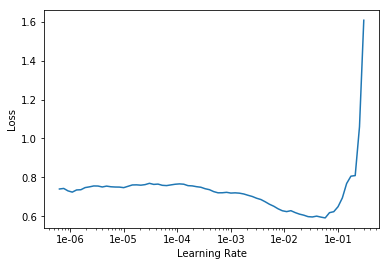

In [114]:
learner.recorder.plot(skip_end=1)

In [115]:
learner.fit_one_cycle(5, 1e-3, moms=(0.8,0.7)) # overfitting? add drop_mult

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.586375,0.291230,0.538444,25:14
1,0.258195,0.209742,0.457675,25:22
2,0.125820,0.179224,0.423116,24:31
3,0.064920,0.189812,0.435605,25:28
4,0.035754,0.178548,0.422183,25:58


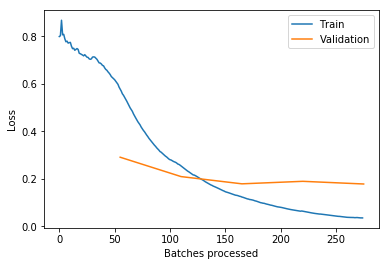

In [116]:
learner.recorder.plot_losses()

In [117]:
learner.save('trained_model_jul22')

In [118]:
learner.load('trained_model_jul22')
learner.freeze_to(-2)

Learner(data=DataBunch;

Train: <fastai_tabtext2.ConcatDataset object at 0x7efd2439f240>;

Valid: <fastai_tabtext2.ConcatDataset object at 0x7efd247309b0>;

Test: None, model=ConcatModel(
  (mod_tab): TabularModel(
    (embeds): ModuleList(
      (0): Embedding(1676, 102)
      (1): Embedding(3, 3)
      (2): Embedding(3, 3)
      (3): Embedding(3, 3)
      (4): Embedding(3, 3)
      (5): Embedding(3, 3)
      (6): Embedding(2, 2)
      (7): Embedding(19, 8)
      (8): Embedding(13, 7)
      (9): Embedding(53, 15)
      (10): Embedding(32, 11)
      (11): Embedding(8, 5)
      (12): Embedding(354, 43)
    )
    (emb_drop): Dropout(p=0.0)
    (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=210, out_features=500, bias=True)
      (1): ReLU(inplace)
    )
  )
  (mod_nlp): SequentialRNN(
    (0): MultiBatchEncoder(
      (module): AWD_LSTM(
        (encoder): Embedding(60004, 400, padding_idx=

In [ ]:
learner.fit_one_cycle(2, slice(1e-03), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,0.024707,0.177659,0.420904,25:38


In [ ]:
learner.save('trained_model2_jul22')

In [ ]:
learner.load('trained_model2_jul22')

In [ ]:
pred, raw_pred = predict_one_item(learner, test[2213], tab_db, text_db)

In [ ]:
pred,raw_pred

In [ ]:
learner.export('trained_model_jul22.pkl')

In [ ]:
learner.model.state_dict()

In [ ]:
text_learner